## Physics-Informed Neural Networks on Darcy Flow below a Water Reservoir

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Read Excel (uploaded file)
reservoir_width = 100
catchment_width = 30
dam_width = 20
aquifer_height = 40

kf = 1e-6 * 60 * 60 * 24  # m/d

fname = '55_5_25.xlsx'
h_path = "./heads/" + fname
v_path = "./velocities/" + fname
h_df = pd.read_excel(h_path)
v_df = pd.read_excel(v_path)
h_df.columns = h_df.columns.str.strip()  
v_df.columns = v_df.columns.str.strip() 

print("Columns:", h_df.columns.tolist())
print("Columns:", v_df.columns.tolist())

reservoir_height, catchment_height, dam_depth = [int(h) for h in fname.split('.')[0].split('_')]

print(f"h1: {reservoir_height}, h2: {catchment_height}, hd: {dam_depth}")

Columns: ['ID', 'X', 'Y', 'Node', 'FINIT', 'FINIT_U']
Columns: ['ID', 'X', 'Y', 'Node', 'VINIT', 'VINIT_U']
h1: 55, h2: 5, hd: 25


In [58]:
# Coordinates
xh_data = h_df['X'].values.astype(np.float32)
yh_data = h_df['Y'].values.astype(np.float32)
# Data
h_data = h_df['FINIT'].values.astype(np.float32)
v_data = v_df['VINIT'].values.astype(np.float32) 

print(f"x_max: {xh_data.max()}, x_min: {xh_data.min()}")
print(f"y_max: {yh_data.max()}, y_min: {yh_data.min()}")

x_max: 150.0, x_min: 0.0
y_max: 40.0, y_min: 0.0


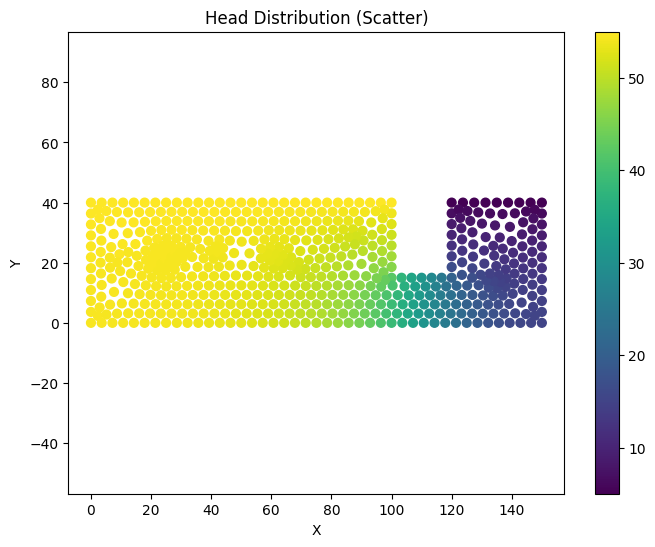

In [3]:
plt.figure(figsize=(8, 6))
sc = plt.scatter(xh_data, yh_data, c=h_data, cmap='viridis', s=40)
cbar = plt.colorbar(sc)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Head Distribution (Scatter)')
plt.axis('equal')
plt.show()

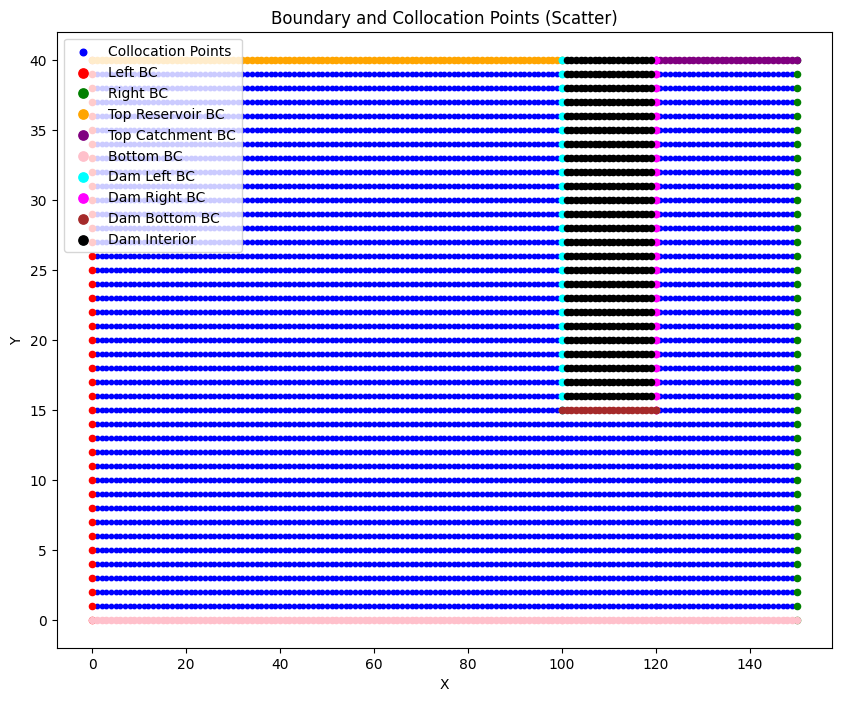

In [4]:
x_res = np.linspace(0, reservoir_width, reservoir_width+1)
y_res = np.linspace(0, aquifer_height, aquifer_height+1)
X_res, Y_res = np.meshgrid(x_res, y_res)
xy_res = np.stack([X_res.ravel(), Y_res.ravel()], axis=1)

x_dam = np.linspace(reservoir_width, reservoir_width + dam_width, dam_width+1)
y_dam = np.linspace(0, aquifer_height, aquifer_height+1)
X_dam, Y_dam = np.meshgrid(x_dam, y_dam)
xy_dam = np.stack([X_dam.ravel(), Y_dam.ravel()], axis=1)


x_catch = np.linspace(reservoir_width + dam_width, reservoir_width + dam_width + catchment_width, catchment_width+1)
y_catch = y_res
X_catch, Y_catch = np.meshgrid(x_catch, y_catch)
xy_catch = np.stack([X_catch.ravel(), Y_catch.ravel()], axis=1)

xy_all = np.vstack([xy_res, xy_dam, xy_catch])

tol = 1e-6
left_bc_mask = np.isclose(xy_all[:, 0], xh_data.min(), atol=tol)
right_bc_mask = np.isclose(xy_all[:, 0], xh_data.max(), atol=tol)
top_res_bc_mask = (np.isclose(xy_all[:, 1], yh_data.max(), atol=tol) & (xy_all[:, 0] <= reservoir_width + tol))
top_catch_bc_mask = (np.isclose(xy_all[:, 1], yh_data.max(), atol=tol) & (xy_all[:, 0] >= (reservoir_width + dam_width) - tol))
bottom_bc_mask = np.isclose(xy_all[:, 1], yh_data.min(), atol=tol)
dam_left_bc_mask = (np.isclose(xy_all[:, 0], reservoir_width, atol=tol) & (xy_all[:, 1] >= (aquifer_height - dam_depth)))
dam_right_bc_mask = (np.isclose(xy_all[:, 0], reservoir_width + dam_width, atol=tol) & (xy_all[:, 1] >= (aquifer_height - dam_depth)))
dam_bot_bc_mask = np.isclose(xy_all[:, 1], (aquifer_height - dam_depth), atol=tol) & (xy_all[:, 0] >= reservoir_width) & (xy_all[:, 0] <= reservoir_width + dam_width)
dam_interior_mask = (xy_all[:, 0] > reservoir_width) & (xy_all[:, 0] < reservoir_width + dam_width) & (xy_all[:, 1] > (aquifer_height - dam_depth))

boundary_mask = (
    left_bc_mask | right_bc_mask | top_res_bc_mask | top_catch_bc_mask |
    bottom_bc_mask | dam_left_bc_mask | dam_right_bc_mask | dam_bot_bc_mask | dam_interior_mask
)
collocation_mask = ~boundary_mask

col_pde = xy_all[collocation_mask]
col_left_bc = xy_all[left_bc_mask]
col_right_bc = xy_all[right_bc_mask]
col_top_res_bc = xy_all[top_res_bc_mask]
col_top_catch_bc = xy_all[top_catch_bc_mask]
col_bottom_bc = xy_all[bottom_bc_mask]
col_dam_left_bc = xy_all[dam_left_bc_mask]
col_dam_right_bc = xy_all[dam_right_bc_mask]
col_dam_bot_bc = xy_all[dam_bot_bc_mask]
col_dam_interior = xy_all[dam_interior_mask]

plt.figure(figsize=(10, 8))
plt.scatter(col_pde[:, 0], col_pde[:, 1], color='blue', s=10, label='Collocation Points')
plt.scatter(col_left_bc[:, 0], col_left_bc[:, 1], color='red', s=20, label='Left BC')
plt.scatter(col_right_bc[:, 0], col_right_bc[:, 1], color='green', s=20, label='Right BC')
plt.scatter(col_top_res_bc[:, 0], col_top_res_bc[:, 1], color='orange', s=20, label='Top Reservoir BC')
plt.scatter(col_top_catch_bc[:, 0], col_top_catch_bc[:, 1], color='purple', s=20, label='Top Catchment BC')
plt.scatter(col_bottom_bc[:, 0], col_bottom_bc[:, 1], color='pink', s=20, label='Bottom BC')
plt.scatter(col_dam_left_bc[:, 0], col_dam_left_bc[:, 1], color='cyan', s=20, label='Dam Left BC')
plt.scatter(col_dam_right_bc[:, 0], col_dam_right_bc[:, 1], color='magenta', s=20, label='Dam Right BC')
plt.scatter(col_dam_bot_bc[:, 0], col_dam_bot_bc[:, 1], color='brown', s=20, label='Dam Bottom BC')
plt.scatter(col_dam_interior[:, 0], col_dam_interior[:, 1], color='black', s=20, label='Dam Interior')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Boundary and Collocation Points (Scatter)')
plt.legend(markerscale=1.5, fontsize=10)
plt.show()

In [5]:
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cpu")
DTYPE = torch.float32

In [6]:
# x_star = reservoir_height + catchment_height + dam_depth
# y_star = aquifer_height
h_star = max(h_data)
x_star = h_star
y_star = h_star

def normalize_coordinates(xy):
    x_norm = xy[:, 0:1] / x_star
    y_norm = xy[:, 1:2] / y_star
    return np.column_stack((x_norm, y_norm))

col_pde_norm = torch.tensor(normalize_coordinates(col_pde), requires_grad=True, dtype=DTYPE, device=DEVICE)
col_left_bc_norm = torch.tensor(normalize_coordinates(col_left_bc), requires_grad=True, dtype=DTYPE, device=DEVICE)
col_right_bc_norm = torch.tensor(normalize_coordinates(col_right_bc), requires_grad=True, dtype=DTYPE, device=DEVICE)
col_top_res_bc_norm = torch.tensor(normalize_coordinates(col_top_res_bc), requires_grad=True, dtype=DTYPE, device=DEVICE)
col_top_catch_bc_norm = torch.tensor(normalize_coordinates(col_top_catch_bc), requires_grad=True, dtype=DTYPE, device=DEVICE)
col_bottom_bc_norm = torch.tensor(normalize_coordinates(col_bottom_bc), requires_grad=True, dtype=DTYPE, device=DEVICE)
col_dam_left_bc_norm = torch.tensor(normalize_coordinates(col_dam_left_bc), requires_grad=True, dtype=DTYPE, device=DEVICE)
col_dam_right_bc_norm = torch.tensor(normalize_coordinates(col_dam_right_bc), requires_grad=True, dtype=DTYPE, device=DEVICE)
col_dam_bot_bc_norm = torch.tensor(normalize_coordinates(col_dam_bot_bc), requires_grad=True, dtype=DTYPE, device=DEVICE)
col_dam_interior_norm = torch.tensor(normalize_coordinates(col_dam_interior), requires_grad=True, dtype=DTYPE, device=DEVICE)

In [7]:
class MLP(nn.Module):
    def __init__(self, layers, activation=nn.Tanh):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:
                self.layers.append(activation())
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [8]:
class PINN(nn.Module):
    def __init__(self, net1_arc, act=nn.Tanh):
        super().__init__()
        self.h_net = MLP(net1_arc, act)

    def forward(self, x):
        h = self.h_net(x)
        return h
    
    def pde_res(self, x):
        h = self.h_net(x)
        dh = torch.autograd.grad(h, x, grad_outputs=torch.ones_like(h), create_graph=True)[0]
        ddh = torch.autograd.grad(dh, x, grad_outputs=torch.ones_like(dh), create_graph=True)[0]
        h_xx = ddh[:, 0:1].unsqueeze(1) 
        h_yy = ddh[:, 1:2].unsqueeze(1)

        return h_xx + h_yy
    
    def h_x(self, x):
        h = self.h_net(x)
        dh = torch.autograd.grad(h, x, grad_outputs=torch.ones_like(h), create_graph=True)[0]
        return dh[:, 0:1].unsqueeze(1)
    
    def h_y(self, x):
        h = self.h_net(x)
        dh = torch.autograd.grad(h, x, grad_outputs=torch.ones_like(h), create_graph=True)[0]
        return dh[:, 1:2].unsqueeze(1)

In [9]:
arc = [2] + [60] * 4 + [1]
EPOCHS_ADAM = 200000
EPOCHS_LBFGS = 1000
LR = 1e-3

pde_w = 1.0
data_w = 1.0
bc_w = 1.0

net = PINN(arc).to(DEVICE, DTYPE)

criteria = torch.nn.MSELoss()
opt_adam = torch.optim.Adam(net.parameters(), lr=LR)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_adam, 'min', 0.99, patience=1000)

for epoch in range(EPOCHS_ADAM):
    opt_adam.zero_grad()
    pde_residual = net.pde_res(col_pde_norm)
    pde_loss = criteria(pde_residual, torch.zeros_like(pde_residual))

    bc_top_res_pred = net(col_top_res_bc_norm)
    bc_h1_loss = criteria(bc_top_res_pred, torch.ones_like(bc_top_res_pred) * reservoir_height / h_star)

    bc_top_catch_pred = net(col_top_catch_bc_norm)
    bc_h2_loss = criteria(bc_top_catch_pred, torch.ones_like(bc_top_catch_pred) * catchment_height / h_star)

    bc_left_pred = net.h_x(col_left_bc_norm)
    bc_left_loss = criteria(bc_left_pred, torch.zeros_like(bc_left_pred))

    bc_right_pred = net.h_x(col_right_bc_norm)
    bc_right_loss = criteria(bc_right_pred, torch.zeros_like(bc_right_pred))

    bc_bottom_pred = net.h_y(col_bottom_bc_norm)
    bc_bottom_loss = criteria(bc_bottom_pred, torch.zeros_like(bc_bottom_pred))

    bc_dam_left_pred = net.h_x(col_dam_left_bc_norm)
    bc_dam_left_loss = criteria(bc_dam_left_pred, torch.zeros_like(bc_dam_left_pred))

    bc_dam_right_pred = net.h_x(col_dam_right_bc_norm)
    bc_dam_right_loss = criteria(bc_dam_right_pred, torch.zeros_like(bc_dam_right_pred))

    bc_dam_bot_pred = net.h_y(col_dam_bot_bc_norm)
    bc_dam_bot_loss = criteria(bc_dam_bot_pred, torch.zeros_like(bc_dam_bot_pred))

    bc_loss = (10 * bc_h1_loss + 10 *  bc_h2_loss + bc_left_loss + bc_right_loss + bc_bottom_loss + bc_dam_left_loss + bc_dam_right_loss + bc_dam_bot_loss)

    total_loss = pde_w * pde_loss + bc_w * bc_loss
    
    total_loss.backward()
    opt_adam.step()
    sched.step(total_loss)
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}/{EPOCHS_ADAM}, Loss: {total_loss.item():.2e}, pde_loss: {pde_loss.item():.2e}, bc1_loss: {bc_h1_loss.item():.2e}, bc2_loss: {bc_h2_loss.item():.2e}, bc3_loss: {bc_left_loss.item():.2e}, bc4_loss: {bc_right_loss.item():.2e}, bc5_loss: {bc_bottom_loss.item():.2e}, bc6_loss: {bc_dam_left_loss.item():.2e}, bc7_loss: {bc_dam_right_loss.item():.2e}, bc8_loss: {bc_dam_bot_loss.item():.2e}, lr: {opt_adam.param_groups[0]['lr']:.2e}")


Epoch 0/200000, Loss: 9.41e+00, pde_loss: 2.48e-03, bc1_loss: 9.39e-01, bc2_loss: 1.50e-03, bc3_loss: 3.03e-03, bc4_loss: 4.71e-05, bc5_loss: 2.14e-04, bc6_loss: 8.45e-05, bc7_loss: 5.20e-05, bc8_loss: 3.16e-06, lr: 1.00e-03
Epoch 1000/200000, Loss: 3.73e-01, pde_loss: 2.54e-02, bc1_loss: 2.28e-02, bc2_loss: 2.08e-03, bc3_loss: 5.84e-04, bc4_loss: 2.75e-04, bc5_loss: 2.16e-02, bc6_loss: 3.94e-02, bc7_loss: 2.87e-02, bc8_loss: 7.96e-03, lr: 1.00e-03
Epoch 2000/200000, Loss: 2.47e-01, pde_loss: 4.18e-02, bc1_loss: 7.48e-03, bc2_loss: 1.65e-03, bc3_loss: 1.03e-03, bc4_loss: 1.72e-03, bc5_loss: 2.26e-02, bc6_loss: 5.26e-02, bc7_loss: 2.42e-02, bc8_loss: 1.14e-02, lr: 1.00e-03
Epoch 3000/200000, Loss: 1.68e-01, pde_loss: 2.36e-02, bc1_loss: 5.77e-03, bc2_loss: 5.54e-04, bc3_loss: 5.78e-04, bc4_loss: 1.13e-03, bc5_loss: 1.50e-02, bc6_loss: 1.77e-02, bc7_loss: 3.01e-02, bc8_loss: 1.69e-02, lr: 1.00e-03
Epoch 4000/200000, Loss: 1.48e-01, pde_loss: 2.59e-02, bc1_loss: 4.29e-03, bc2_loss: 6.26e-

R2 score: 0.9678


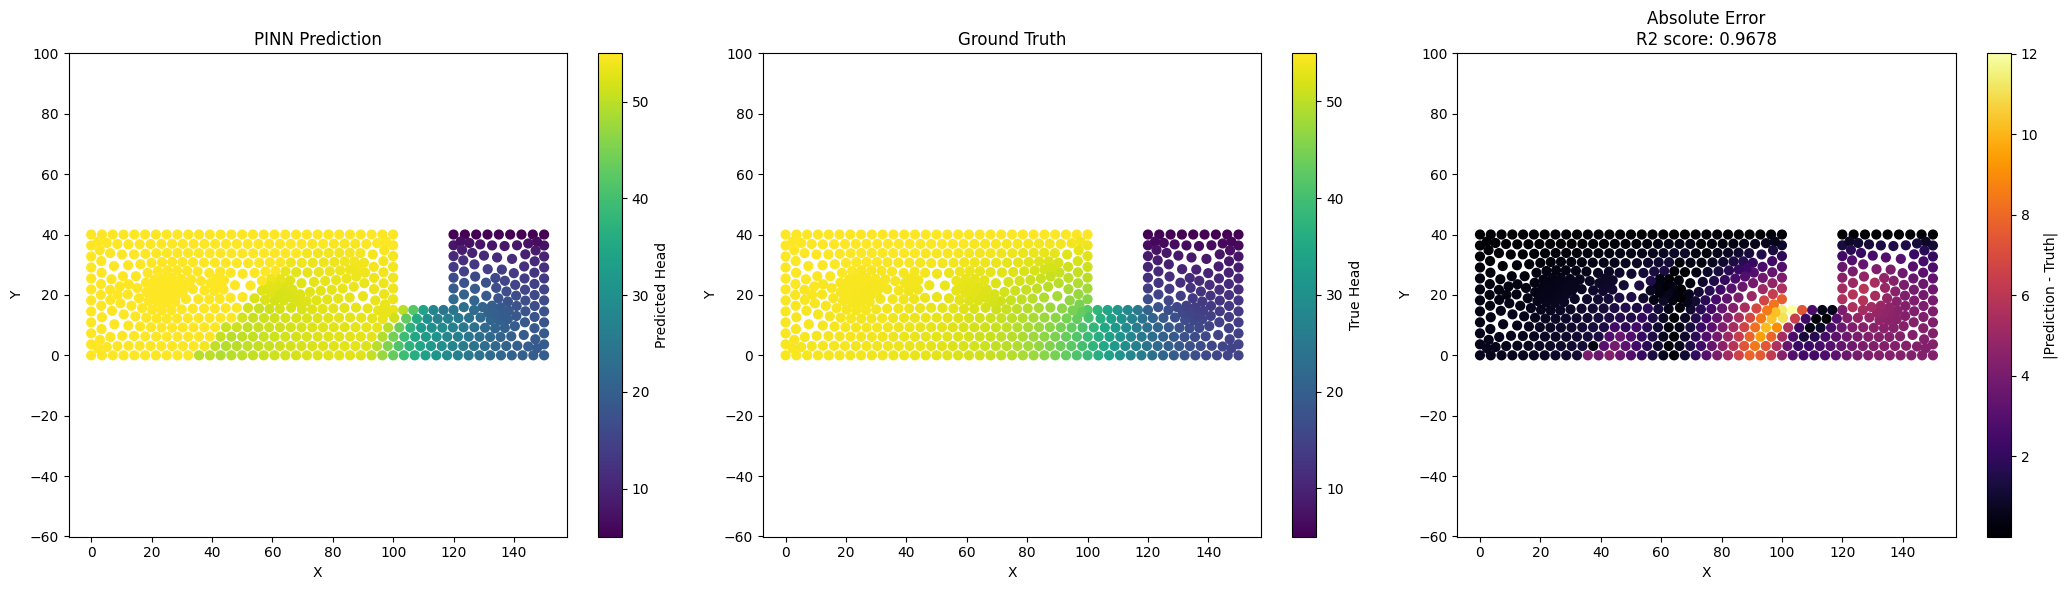

In [17]:
x_test = xh_data.reshape(-1, 1)
y_test = yh_data.reshape(-1, 1)
test_input = np.concatenate((x_test, y_test), axis=1)
test_input = torch.tensor(normalize_coordinates(test_input), dtype=DTYPE, device=DEVICE, requires_grad=True)

h_pred = net(test_input).cpu().detach().numpy() * h_star

from sklearn.metrics import r2_score

r2 = r2_score(h_data.flatten(), h_pred.flatten())
print(f"R2 score: {r2:.4f}")

plt.figure(figsize=(21, 6))

plt.subplot(1, 3, 1)
sc1 = plt.scatter(xh_data, yh_data, c=h_pred, cmap='viridis', s=40)
plt.colorbar(sc1, label='Predicted Head')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('PINN Prediction')
plt.axis('equal')

plt.subplot(1, 3, 2)
sc2 = plt.scatter(xh_data, yh_data, c=h_data, cmap='viridis', s=40)
plt.colorbar(sc2, label='True Head')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Ground Truth')
plt.axis('equal')

plt.subplot(1, 3, 3)
error = np.abs(h_pred.flatten() - h_data.flatten())
sc3 = plt.scatter(xh_data, yh_data, c=error, cmap='inferno', s=40)
plt.colorbar(sc3, label='|Prediction - Truth|')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Absolute Error\nR2 score: {r2:.4f}')
plt.axis('equal')

plt.tight_layout()

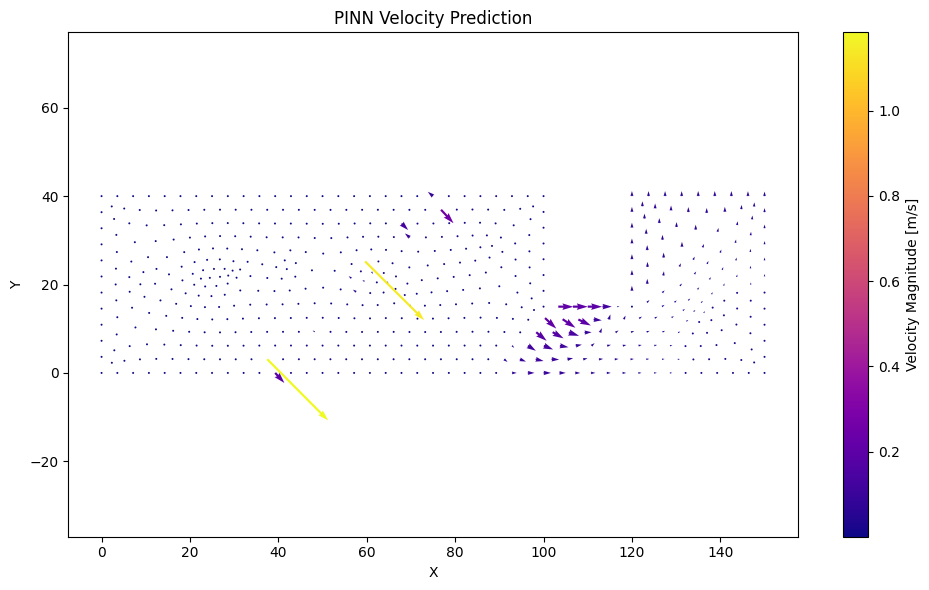

In [67]:
h_x_pred = net.h_x(test_input).cpu().detach().numpy() 
h_y_pred = net.h_y(test_input).cpu().detach().numpy()

vx = -kf * h_x_pred
vy = -kf * h_y_pred
v_pred = np.sqrt(vx**2 + vy**2)
v_data = v_data.reshape(-1, 1)

plt.figure(figsize=(10, 6))

sc1 = plt.quiver(
    xh_data, yh_data, vx.flatten(), vy.flatten(),
    v_pred.flatten(), cmap="plasma", scale=10, width=0.003
)
plt.colorbar(sc1, label="Velocity Magnitude [m/s]")
plt.axis('equal')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('PINN Velocity Prediction')
plt.tight_layout()

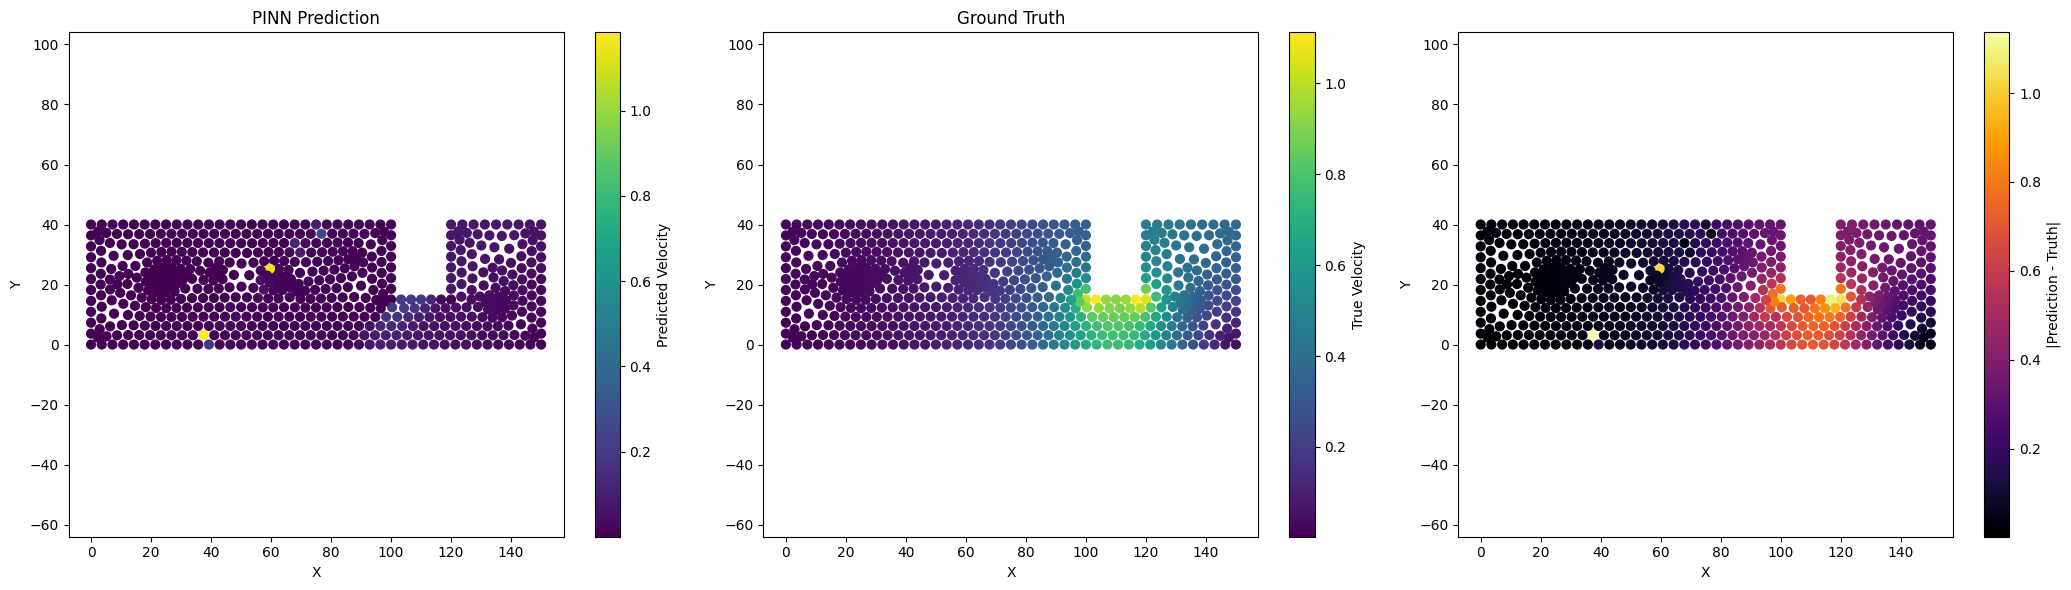

In [61]:
plt.figure(figsize=(21, 6))

plt.subplot(1, 3, 1)
sc1 = plt.scatter(xh_data, yh_data, c=v_pred.flatten(), cmap='viridis', s=40)
plt.colorbar(sc1, label='Predicted Velocity')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('PINN Prediction')
plt.axis('equal')

plt.subplot(1, 3, 2)
sc2 = plt.scatter(xh_data, yh_data, c=v_data.flatten(), cmap='viridis', s=40)
plt.colorbar(sc2, label='True Velocity')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Ground Truth')
plt.axis('equal')

plt.subplot(1, 3, 3)
error_v = np.abs(v_pred.flatten() - v_data.flatten())
sc3 = plt.scatter(xh_data, yh_data, c=error_v, cmap='inferno', s=40)
plt.colorbar(sc3, label='|Prediction - Truth|')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')

plt.tight_layout()